# **Question 7**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

In [3]:
from google.colab import files

uploaded_files = files.upload()

Saving A4_P1.csv to A4_P1.csv


In [4]:
data = pd.read_csv("A4_P1.csv")

In [5]:
X = data[['X1', 'X2']].values
y = data['y'].values

In [6]:
y = np.where(y == 0, -1, 1)

In [7]:
lr = 0.01
epochs = 20

def perceptron_train(X, y, lr, epochs, seed=None):
    if seed is not None:
        np.random.seed(seed)

    w = np.random.randn(3)  # random init: bias + 2 features
    X_aug = np.c_[np.ones(X.shape[0]), X]  # add bias term as first feature

    for epoch in range(epochs):
        for idx in range(len(X_aug)):
            xi = X_aug[idx]
            actual = y[idx]
            guess = 1 if np.dot(w, xi) >= 0 else -1

            if guess != actual:
                update = lr * actual * xi
                w += update

    return w


In [8]:
def draw_decision_boundary(data, labels, w, title="Boundary Visualization"):
    plt.figure(figsize=(8, 6))

    pos_class = data[labels == 1]
    neg_class = data[labels == -1]

    plt.scatter(pos_class[:, 0], pos_class[:, 1], c='blue', label="Positive", edgecolors='k')
    plt.scatter(neg_class[:, 0], neg_class[:, 1], c='red', label="Negative", edgecolors='k')

    x_start = data[:, 0].min() - 1
    x_end = data[:, 0].max() + 1
    y_start = data[:, 1].min() - 1
    y_end = data[:, 1].max() + 1

    x_vals = np.linspace(x_start, x_end, 120)
    y_vals = -(w[0] + w[1] * x_vals) / w[2] if w[2] != 0 else np.full_like(x_vals, 0)

    plt.plot(x_vals, y_vals, color='green', linestyle='-', linewidth=2, label="Decision Line")

    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(visible=True)
    plt.tight_layout()
    plt.show()


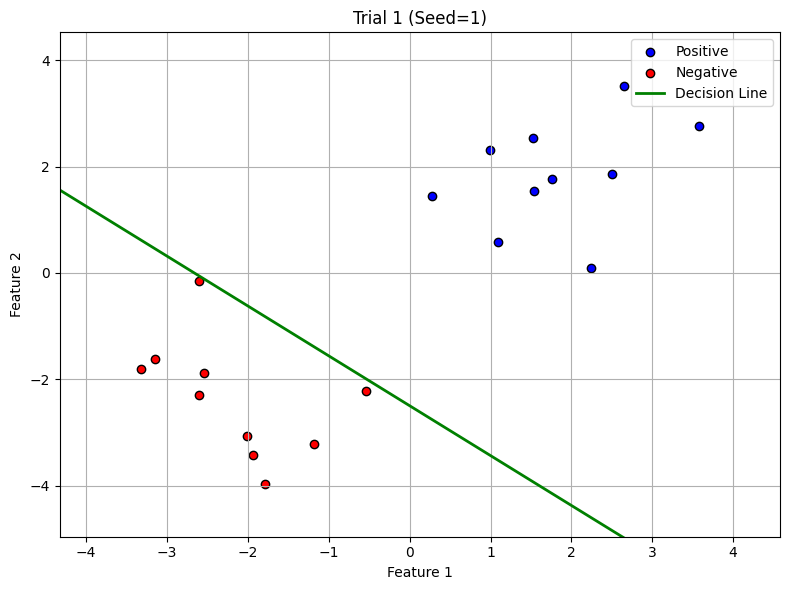

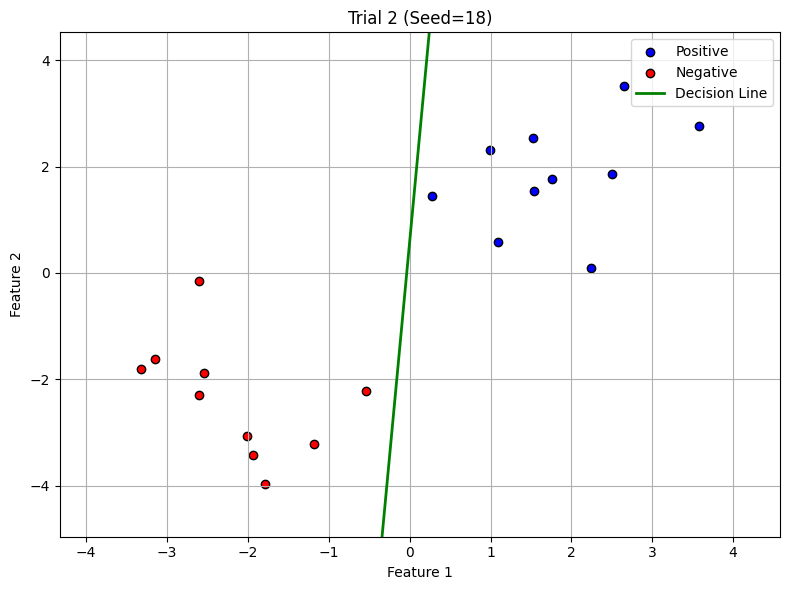

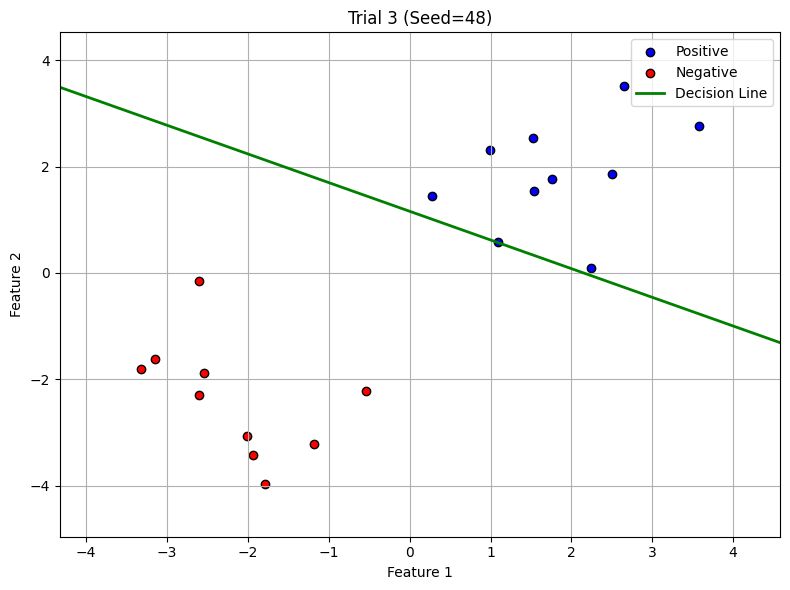

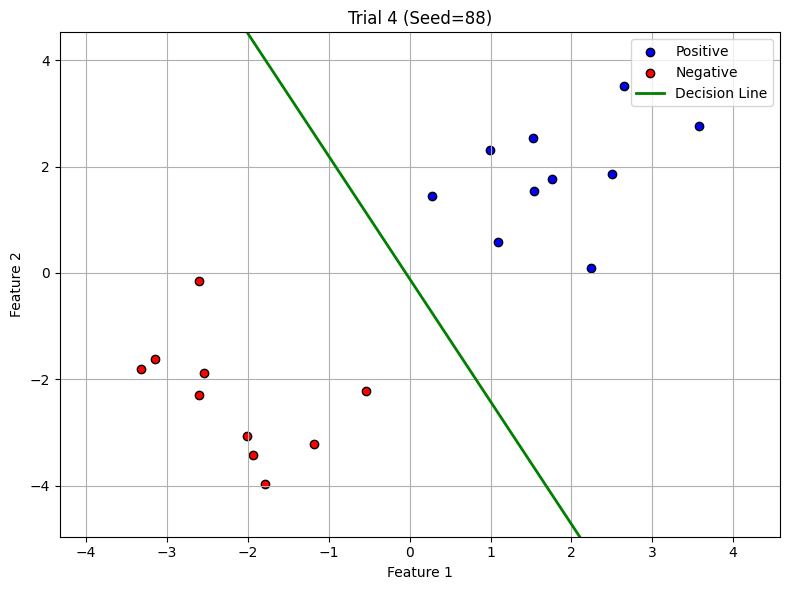

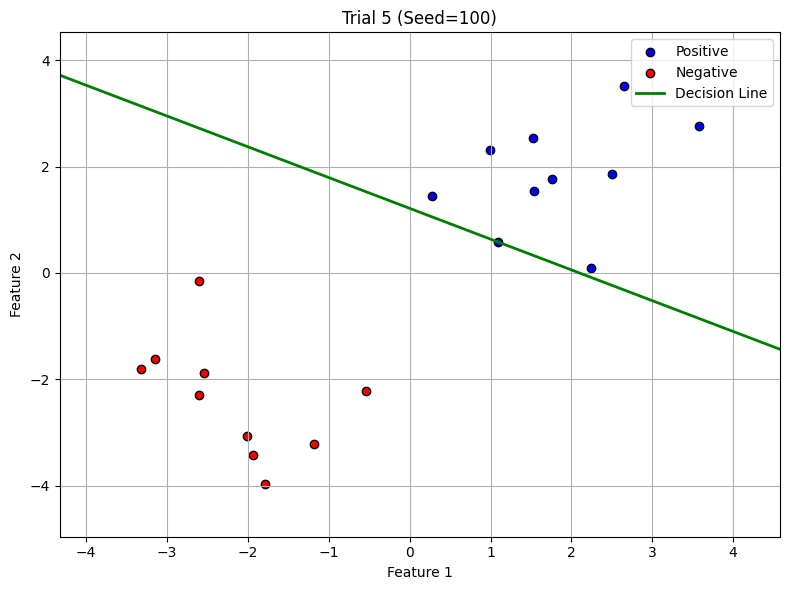

In [9]:
seeds = [1, 18, 48, 88, 100]  # Different seeds for weight initialization
for i, seed in enumerate(seeds):
    weights = perceptron_train(X, y, lr, epochs, seed)
    draw_decision_boundary(X, y, weights, title=f"Trial {i+1} (Seed={seed})")

# **Question 8**

In [10]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [11]:
data = load_iris()
X, y = data.data, data.target

In [12]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Reshaping
y_encoded = y_encoded.reshape(X.shape[0], -1)

# Splitting into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardizing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
input_size = X_train.shape[1]
hidden_size = 5
output_size = y_encoded.shape[1]
learning_rate = 0.01
epochs = 1000

In [14]:
np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))

In [15]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_loss_derivative(y_true, y_pred):
    return y_pred - y_true

In [16]:
train_losses, test_losses = [], []
train_acc, test_acc = [], []

def get_accuracy(true_labels, predicted_probs):
    preds = np.argmax(predicted_probs, axis=1)
    targets = np.argmax(true_labels, axis=1)
    return np.mean(preds == targets)

for ep in range(epochs):
    # Forward pass (train set)
    h1_raw = np.dot(X_train, W1) + b1
    h1_act = tanh(h1_raw)
    out_raw = np.dot(h1_act, W2) + b2
    out_probs = softmax(out_raw)

    train_loss = mse_loss(y_train, out_probs)
    train_losses.append(train_loss)
    train_acc.append(get_accuracy(y_train, out_probs))

    # Backward pass
    grad_output = mse_loss_derivative(y_train, out_probs)
    grad_z2 = grad_output * (out_probs * (1 - out_probs))  # kinda sloppy softmax-MSE gradient

    grad_W2 = np.dot(h1_act.T, grad_z2)
    grad_b2 = np.sum(grad_z2, axis=0, keepdims=True)

    grad_h1 = np.dot(grad_z2, W2.T)
    grad_z1 = grad_h1 * tanh_derivative(h1_raw)

    grad_W1 = np.dot(X_train.T, grad_z1)
    grad_b1 = np.sum(grad_z1, axis=0, keepdims=True)

    # Update weights & biases (SGD style)
    W1 = W1 - lr * grad_W1
    b1 = b1 - lr * grad_b1
    W2 = W2 - lr * grad_W2
    b2 = b2 - lr * grad_b2

    # Validation / test pass
    h1_test = tanh(np.dot(X_test, W1) + b1)
    out_test = softmax(np.dot(h1_test, W2) + b2)

    loss_test = mse_loss(y_test, out_test)
    test_losses.append(loss_test)
    test_acc.append(get_accuracy(y_test, out_test))


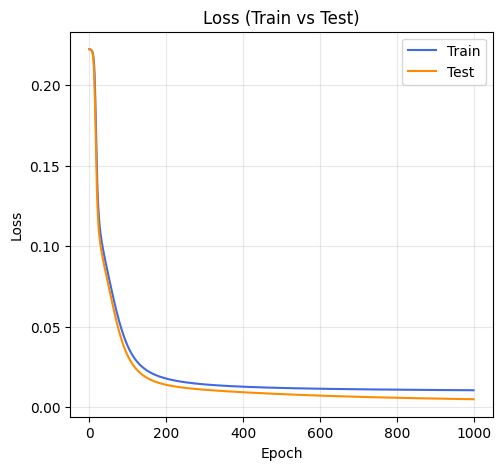

In [17]:
# Loss curves for sanity check
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, color='royalblue', label='Train')
plt.plot(test_losses, color='darkorange', label='Test')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (Train vs Test)')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

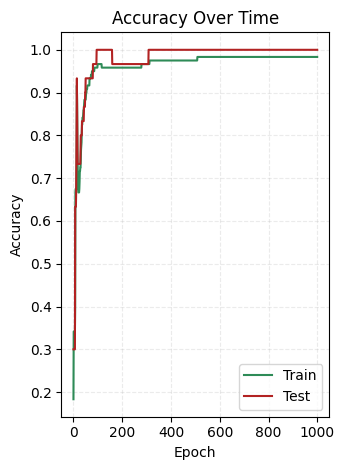

In [18]:
# Accuracy tracking to make sure it's actually learning something
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train', color='seagreen')
plt.plot(test_acc, label='Test', color='firebrick')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.25)

plt.tight_layout()
plt.show()